# Lab 3: Plasticity and learning

In this lab, we will from static circuit to dynamics circuit where the connectivity will change following plasticity rules in un-supervised way or reward-dependent way. 

(Code by Lihao Guo, Questions by Arvind Kumar 2022. The tutorial is inspired by the Neuronal Dynamics book from Wulfram Gerstner, Werner M. Kistler, Richard Naud and Liam Paninski. https://neuronaldynamics.epfl.ch/online/index.html. Last part is from Nengo.)

In [ ]:
#@title Run the following to initialize lab environment.
debug = 'google.colab' not in str(get_ipython())
if not debug:
    import os, sys

    # clone respository
    user = "michaelglh"
    repo = "STG"
    if os.path.isdir(repo):
        !rm -rf {repo}
    !git clone https://github.com/{user}/{repo}.git

    # add path to system
    src_dir = ""
    path = f"{repo}/{src_dir}"
    if not path in sys.path:
        sys.path.insert(1, path)

    from google.colab import output
    output.enable_custom_widget_manager()

    !pip install ipympl==0.8.0 --quiet
    !pip install nengo nengo-gui nengo_extras --quiet

    import matplotlib.backends

In [1]:
#@title Run the following to download necessary files.
from lib.neuron import LIF
from lib.input import Poisson_generator, Gaussian_generator, Current_injector
from lib.conn import Simulator
from lib.helper import plot_volt_trace, pair_volt_trace
    
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats                      
import ipywidgets as widgets            # interactive display
my_layout = widgets.Layout()

import nengo
from nengo_extras.data import load_mnist, one_hot_from_labels
from nengo_extras.matplotlib import tile
from nengo_extras.vision import Gabor, Mask

# setting for figures
fig_w, fig_h = 8, 6
my_fontsize = 18
my_params = {'axes.labelsize': my_fontsize,
          'axes.titlesize': my_fontsize,
          'figure.figsize': (fig_w, fig_h),
          'font.size': my_fontsize,
          'legend.fontsize': my_fontsize-4,
          'lines.markersize': 8.,
          'lines.linewidth': 2.,
          'xtick.labelsize': my_fontsize-2,
          'ytick.labelsize': my_fontsize-2}

plt.rcParams.update(my_params)

# Auto Reloading
%load_ext autoreload
%autoreload 2
%matplotlib widget

### Different types of synaptic plasticities
* Two-factor plasticity
* Spike-timeing-dependent long-term plasticity

interactive(children=(Dropdown(description='c_ts', options=('Static', 'Hebb', 'STDP'), value='Static'), FloatS…

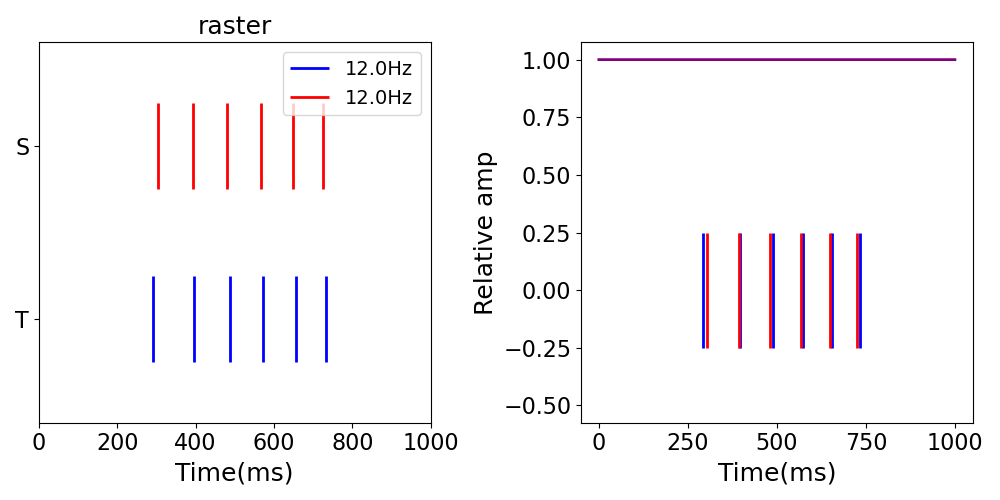

In [2]:
#@title Run the following to start hebbain plasticity simulation { vertical-output: true }
T, dt = 1e3, 0.1        # simulation period(ms), step size(ms)
N = 2                  # number of neurons

# neuron types
tonic_neuron = {'tau_m':20., 'a':0., 'tau_w':30., 'b':3., 'V_reset':-55.}
adapting_neuron = {'tau_m':20., 'a':0., 'tau_w':100., 'b':0.5, 'V_reset':-55.}
initburst_neuron = {'tau_m':10., 'a':0., 'tau_w':100., 'b':1., 'V_reset':-50.}
bursting_neuron = {'tau_m':5., 'a':0., 'tau_w':100., 'b':1., 'V_reset':-46.}
irregular_neuron = {'tau_m':10., 'a':-0.01, 'tau_w':50., 'b':1.2, 'V_reset':-46.}
transient_neuron = {'tau_m':5., 'a':0.05, 'tau_w':100., 'b':0.7, 'V_reset':-60.}
delayed_neuron = {'tau_m':5., 'a':-0.1, 'tau_w':100., 'b':1., 'V_reset':-60.}
rebound_neuron = {'tau_m':5., 'a':0.2, 'tau_w':150., 'b':0.1, 'V_reset':-54.}

neuron_params = {'tonic_neuron': tonic_neuron, 'adapting_neuron': adapting_neuron, 
                 'initburst_neuron': initburst_neuron, 'bursting_neuron': bursting_neuron, 
                 'irregular_neuron': irregular_neuron, 'transient_neuron': transient_neuron, 
                 'delayed_neuron': delayed_neuron, 'rebound_neuron': rebound_neuron}
    
# input types
Itypes = ['Gaussian', 'Poisson']

# connection types
Ctypes = ['Static', 'Hebb', 'STDP']

# updating parameters
def update_pls(c_ts='Static', J_ts=1.0, rt=50., rs=50., Itype='Icur'):
    # simualtor
    h = Simulator(dt=dt)

    # network of neurons
    nrns = [LIF(sim=h) for _ in range(N)]
    for nrn in nrns:
        nrn.update(tonic_neuron)

    # background noise
    if Itype == 'Gaussian':
        noises = [Gaussian_generator(sim=h, mean=r, std=r, start=int(T/dt*0.25), end=int(T/dt*0.75)) for r in [rt, rs]]
    elif Itype == 'Poisson':
        noises = [Poisson_generator(sim=h, rate=r*3, start=int(T/dt*0.25), end=int(T/dt*0.75)) for r in [rt, rs]]
    else:
        print('Invalid input')
    for noise, nrn in zip(noises, nrns):
        nrn.connect(noise, {'ctype':'Static', 'weight':1e0, 'delay':5})      

    # recurrent connections
    tps = [['Static' for _ in range(N)] for _ in range(N)]
    tps[0][1] = c_ts
    con = np.array([[0., J_ts],
                    [0., 0.]])
    dly = np.random.uniform(2., 5., (N,N))
    synspecs = [[{} for _ in range(N)] for _ in range(N)]
    for i in range(N):
        for j in range(N):
            synspecs[i][j] = {'ctype':tps[i][j], 'weight':con[i,j], 'delay':dly[i,j]}
    cons = h.connect(nrns, nrns, synspecs)

    # simulation
    h.run(T)

    # visualize
    plt.clf()
    cs = ['b', 'r']
    plt.subplot(1,2,1)
    plt.title('raster')
    for nrn, c, l in zip(nrns, cs, range(N)):
        plt.eventplot(nrn.spikes['times'], lineoffsets=2*l, colors=c, label='%.1fHz'%(len(nrn.spikes['times'])/T*1e3*2))
    plt.xlabel('Time(ms)')
    plt.yticks(list(np.arange(N)*2), ['T', 'S'])
    plt.xlim([0., T])
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(np.arange(0., T, dt), cons[0][1].weights, c='purple')
    for nrn, c in zip(nrns, cs):
        plt.eventplot(nrn.spikes['times'], lineoffsets=0, linelengths=0.5, colors=c)
    plt.xlabel('Time(ms)')
    plt.ylabel('Relative amp')
    plt.tight_layout()

try:
    plt.close(fig_pls)
except:
    ...
fig_pls, axes = plt.subplots(1,2,figsize=(10,5))
widgets.interact(update_pls, c_ts=Ctypes, J_ts=(0.01, 2., 0.01), rt=(0., 100., 10.), rs=(0., 100., 10.), Itype=Itypes);

### Learning

* Unsupervised competitive learning (rate model)
* Encoding/decoding with receptive field

<img src="./figs/encoding.png" alt="Encoding network" width="1200"/>

GridspecLayout(children=(Text(value='center', disabled=True, layout=Layout(grid_area='widget001', width='200px…

Output()

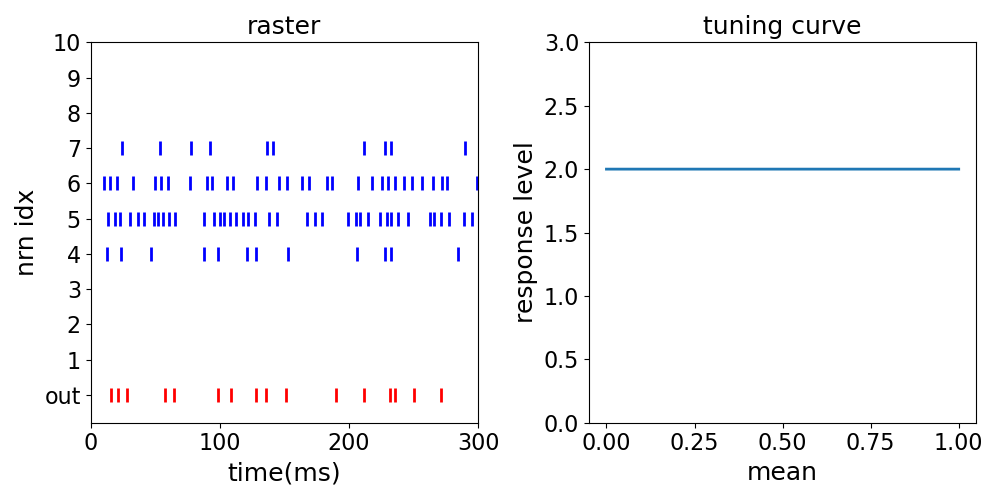

In [41]:
#@title Run the following to start competitive learning { vertical-output: true }
T, dt = 3e2, 0.1        # simulation period(ms), step size(ms)
N = 11                  # number of neurons

# inputs
ms, std, xs = np.linspace(0., 1., 101), 0.1, np.linspace(0.05-1e-5, 0.95-1e-5, N-1)
rins = [np.array([max(scipy.stats.norm(mean, std).pdf([x, x-1, 1+x]))  for x in xs]) for mean in ms]

# weights
grid = widgets.GridspecLayout(2, N)
wsize = '200px'
for i, label in enumerate(['center'] + ['J_o%d'%i for i in np.arange(1, N)]):
    grid[0, i] = widgets.Text(value=label, disabled=True, layout=widgets.Layout(width=wsize))
for i in np.arange(1, N):
    grid[1, i] = widgets.FloatSlider(value=0.2, min=0.0, max=0.4, step=0.01, layout=widgets.Layout(width=wsize))
grid[1, 0] = widgets.FloatSlider(value=0.5, min=0.0, max=1.0, step=0.01, layout=widgets.Layout(width=wsize))

con_bars = {}
con_bars['mean'] = grid[1, 0]
for i in np.arange(1, N):
    con_bars['J_o%d'%i] = grid[1, i]

# updating parameters
def update_tune(**con_dict):
    # simualtor
    h = Simulator(dt=dt)

    # network of neurons
    nrns = [LIF(sim=h) for _ in range(N)]
    for nrn in nrns:
        nrn.update(tonic_neuron)

    # input and weights
    cons = np.array(list(con_dict.values()), dtype=float)
    mean, ws = cons[0], cons[1:] 

    # background noise
    rdist = [max(scipy.stats.norm(mean, std).pdf([x, x-1, 1+x])) for x in xs]
    rs = np.array([0.5] + rdist)*1e2
    noises = [Poisson_generator(sim=h, rate=r*3, start=0, end=int(T/dt)) for r in rs]
    for noise, nrn in zip(noises, nrns):
        nrn.connect(noise, {'ctype':'Static', 'weight':1e0, 'delay':5})      

    # recurrent connections
    tps = [['Static' for _ in range(N)] for _ in range(N)]
    con = np.zeros((N,N))
    con[0, 1:] = ws * 5
    dly = np.random.uniform(2., 5., (N,N))
    synspecs = [[{} for _ in range(N)] for _ in range(N)]
    for i in range(N):
        for j in range(N):
            synspecs[i][j] = {'ctype':tps[i][j], 'weight':con[i,j], 'delay':dly[i,j]}
    h.connect(nrns, nrns, synspecs)

    # simulation
    h.run(T)

    # save weight
    ys = np.array([np.dot(ws, rin) for rin in rins])

    # visualize
    plt.clf()
    plt.subplot(1,2,1)
    plt.title('raster')
    for nrn, l in zip(nrns, range(N)):
        if l == 0:
            plt.eventplot(nrn.spikes['times'], colors='r', lineoffsets=l, linelengths=0.4, label='%.1fHz'%(len(nrn.spikes['times'])/T*1e3*2))
        else:
            plt.eventplot(nrn.spikes['times'], colors='b', lineoffsets=l, linelengths=0.4, label='%.1fHz'%(len(nrn.spikes['times'])/T*1e3*2))
    plt.xlabel('time(ms)')
    plt.yticks(list(np.arange(N)), ['out'] + list(np.arange(1, N)))
    plt.ylabel('nrn idx')
    plt.xlim([0., T])

    plt.subplot(1,2,2)
    plt.title('tuning curve')
    plt.plot(ms, ys)
    plt.xlabel('mean')
    plt.ylabel('response level')
    plt.ylim([0, 3])

    plt.tight_layout()

try:
    plt.close(fig_tune)
except:
    ...
fig_tune, axes = plt.subplots(1,2,figsize=(10,5))
widget_tune = widgets.interactive_output(update_tune, con_bars);
display(grid, widget_tune);

interactive(children=(FloatSlider(value=0.5, description='mean', max=1.0, step=0.01), FloatSlider(value=0.1, d…

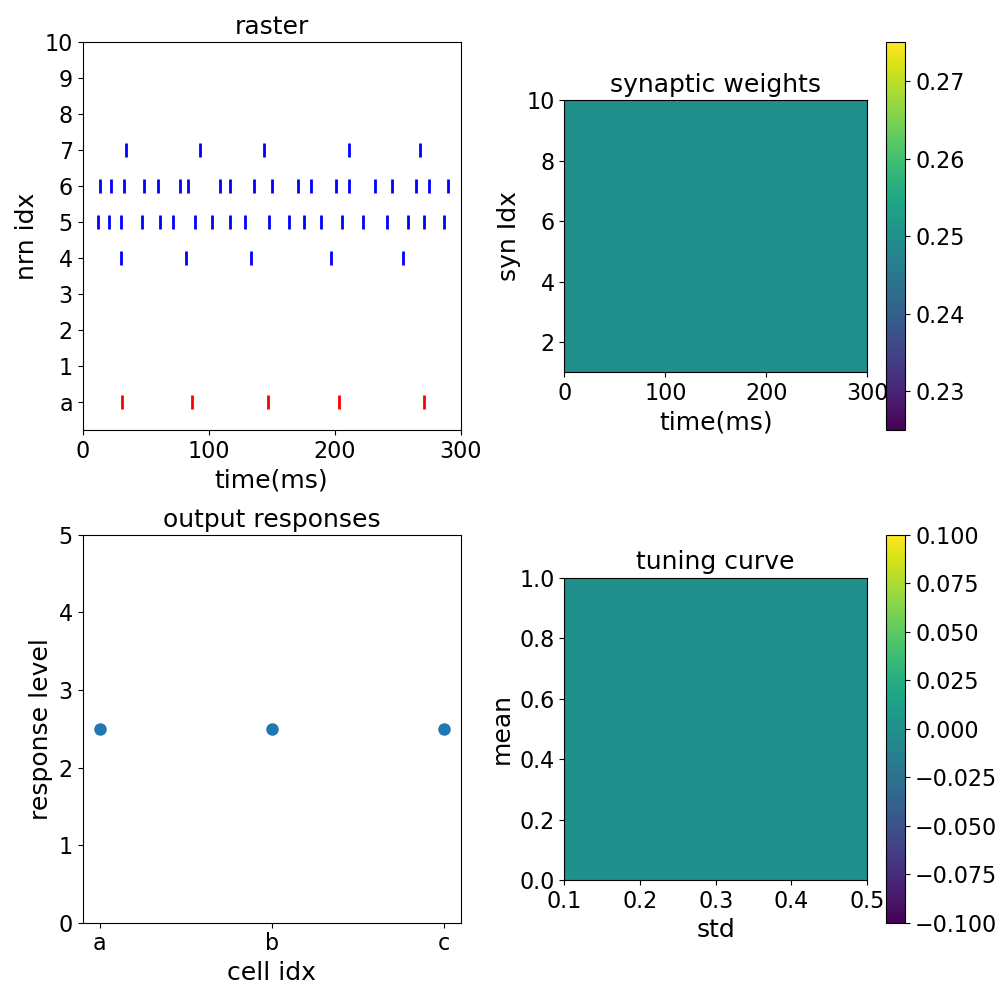

In [42]:
#@title Run the following to start competitive learning { vertical-output: true }
T, dt = 3e2, 0.1        # simulation period(ms), step size(ms)
N = 11                  # number of neurons

# output neurons
out_labels = ['a', 'b', 'c']
M = len(out_labels)                   # number of cells

# inputs
std_low, std_high = 0.1, 0.5
ms, ss, xs = np.linspace(0., 1., 11), np.linspace(std_low, std_high, 11), np.linspace(0.05-1e-5, 0.95-1e-5, N-1)
rins = np.array([[[max(scipy.stats.norm(mean, std).pdf([x, x-1, 1+x])) for x in xs] for std in ss] for mean in ms]) 

# weights
ws = np.ones((M, N-1)) * 0.25

# outputs
ys = np.zeros((M, len(ms), len(ss)))

# updating parameters
def update_comp(mean=0.5, std=0.1,  outIdx='a', plasticity=False, Itype='Icur'):
    nIdx = out_labels.index(outIdx)
    # simualtor
    h = Simulator(dt=dt)

    # network of neurons
    nrns = [LIF(sim=h) for _ in range(N)]
    for nrn in nrns:
        nrn.update(tonic_neuron)

    # background noise
    rdist = [max(scipy.stats.norm(mean, std).pdf([x, x-1, 1+x])) for x in xs]
    rs = np.array([1.0] + rdist)*5e2/np.sum(rdist)
    if Itype == 'Gaussian':
        noises = [Gaussian_generator(sim=h, mean=r, std=r, start=0, end=int(T/dt)) for r in rs]
    elif Itype == 'Poisson':
        noises = [Poisson_generator(sim=h, rate=r*3, start=0, end=int(T/dt)) for r in rs]
    else:
        print('Invalid input')
    for noise, nrn in zip(noises, nrns):
        nrn.connect(noise, {'ctype':'Static', 'weight':1e0, 'delay':5})      

    # recurrent connections
    tps = [['Static' for _ in range(N)] for _ in range(N)]
    if plasticity:
        for i in np.arange(1, N):
            tps[0][i] = 'Comp'
    con = np.zeros((N,N))
    global ws
    global ys
    con[0, 1:] = ws[nIdx]
    dly = np.random.uniform(2., 5., (N,N))
    synspecs = [[{} for _ in range(N)] for _ in range(N)]
    for i in range(N):
        for j in range(N):
            synspecs[i][j] = {'ctype':tps[i][j], 'weight':con[i,j], 'delay':dly[i,j]}
    cons = h.connect(nrns, nrns, synspecs)

    # simulation
    h.run(T)

    # save weight
    if plasticity:
        ws[nIdx] = np.array([cons[0][i].weights[-1] for i in np.arange(1, N)])
        for i in range(len(ms)):
            for j in range(len(ss)):
                ys[nIdx, i, j] = np.dot(ws[nIdx], rins[i,j])
    responses = np.array([np.dot(ws[i], rdist) for i in range(M)])
    

    # visualize
    plt.clf()
    plt.subplot(2,2,1)
    plt.title('raster')
    for nrn, l in zip(nrns, range(N)):
        if l == 0:
            plt.eventplot(nrn.spikes['times'], colors='r', lineoffsets=l, linelengths=0.4, label='%.1fHz'%(len(nrn.spikes['times'])/T*1e3*2))
        else:
            plt.eventplot(nrn.spikes['times'], colors='b', lineoffsets=l, linelengths=0.4, label='%.1fHz'%(len(nrn.spikes['times'])/T*1e3*2))
    plt.xlabel('time(ms)')
    plt.yticks(list(np.arange(N)), [outIdx] + list(np.arange(1, N)))
    plt.ylabel('nrn idx')
    plt.xlim([0., T])

    plt.subplot(2,2,2)
    plt.title('synaptic weights')
    if plasticity:
        weights = np.array([cons[0][i].weights for i in np.arange(1, N)])
        plt.imshow(weights[:, np.arange(0, int(T/dt), 100)], extent=[0, T, 1, 10], origin='lower', aspect=30)
    else:
        plt.imshow(np.tile(ws[nIdx], (int(T/dt/100), 1)).T, extent=[0, T, 1, 10], origin='lower', aspect=30)
    plt.xlabel('time(ms)')
    plt.ylabel('syn Idx')
    plt.colorbar()

    plt.subplot(2,2,4)
    plt.title('tuning curve')
    plt.imshow(ys[nIdx], extent=[std_low, std_high, 0., 1.0], origin='lower', aspect=std_high - std_low)
    plt.xlabel('std')
    plt.ylabel('mean')
    plt.colorbar()

    plt.subplot(2,2,3)
    plt.title('output responses')
    plt.scatter(range(M), responses)
    plt.xlabel('cell idx')
    plt.xticks(list(np.arange(M)), out_labels)
    plt.ylabel('response level')
    plt.ylim([0, 5])

    plt.tight_layout()

try:
    plt.close(fig_comp)
except:
    ...
fig_comp, axes = plt.subplots(2,2,figsize=(10,10))
widgets.interact(update_comp, mean=(0., 1.0, 0.01), std=(std_low, std_high, 0.01), outIdx=out_labels, plasticity=[True, False], Itype=Itypes);

interactive(children=(Dropdown(description='encoder', options=('dense_normal', 'sparse_normal', 'dense_gabor',…

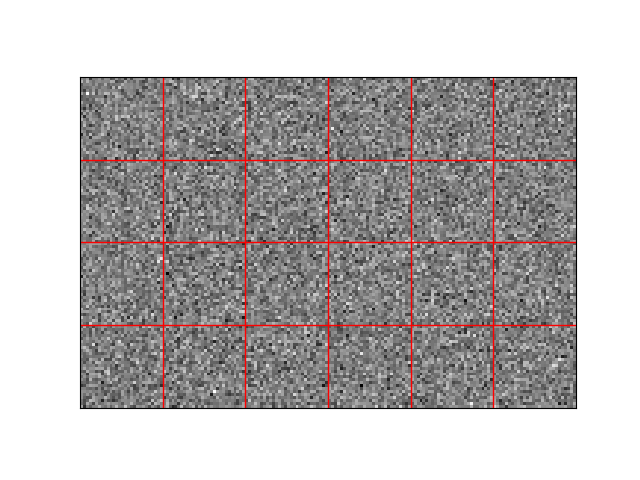

In [43]:
rng = np.random.RandomState(9)

# --- load the data
img_rows, img_cols = 28, 28

# pylint: disable=unbalanced-tuple-unpacking
(X_train, y_train), (X_test, y_test) = load_mnist("./data/mnist.pkl.gz")
X_train = 2 * X_train - 1  # normalize to -1 to 1
X_test = 2 * X_test - 1  # normalize to -1 to 1

T_train = one_hot_from_labels(y_train, classes=10)

# --- set up network parameters
n_vis = X_train.shape[1]
n_out = T_train.shape[1]

# number of hidden units
# More means better performance but longer training time.
n_hid = 1000

ens_params = dict(
    eval_points=X_train,
    neuron_type=nengo.LIFRate(),
    intercepts=nengo.dists.Choice([0.1]),
    max_rates=nengo.dists.Choice([100]),
)

solver = nengo.solvers.LstsqL2(reg=0.01)

with nengo.Network(seed=3) as model:
    a = nengo.Ensemble(n_hid, n_vis, **ens_params)
    v = nengo.Node(size_in=n_out)
    conn = nengo.Connection(
        a, v, synapse=None, eval_points=X_train, function=T_train, solver=solver
    )


def get_outs(simulator, images):
    # encode the images to get the ensemble activations
    _, acts = nengo.utils.ensemble.tuning_curves(a, simulator, inputs=images)

    # decode the ensemble activities using the connection's decoders
    return np.dot(acts, simulator.data[conn].weights.T)


def get_error(simulator, images, labels):
    # the classification for each example is index of
    # the output dimension with the highest value
    return np.argmax(get_outs(simulator, images), axis=1) != labels


def print_error(simulator):
    train_error = 100 * get_error(simulator, X_train, y_train).mean()
    test_error = 100 * get_error(simulator, X_test, y_test).mean()
    print("Train/test error: %0.2f%%, %0.2f%%" % (train_error, test_error))

# updating parameters
encoder_labels = ['dense_normal', 'sparse_normal', 'dense_gabor', 'sparse_gabor']

def update_vis(encoder='dense_normal'):
    if encoder_labels.index(encoder) == 0:
        encoders = rng.normal(size=(n_hid, 28 * 28))
    elif encoder_labels.index(encoder) == 1:
        encoders = rng.normal(size=(n_hid, 11, 11))
        encoders = Mask((28, 28)).populate(encoders, rng=rng, flatten=True)
    elif encoder_labels.index(encoder) == 2:
        encoders = Gabor().generate(n_hid, (28, 28), rng=rng).reshape((n_hid, -1))
    elif encoder_labels.index(encoder) == 3:
        encoders = Gabor().generate(n_hid, (11, 11), rng=rng)
        encoders = Mask((28, 28)).populate(encoders, rng=rng, flatten=True)
    a.encoders = encoders

    plt.clf()
    tile(encoders.reshape((-1, 28, 28)), rows=4, cols=6, grid=True)

    with nengo.Simulator(model) as sim:
        print_error(sim)

try:
    plt.close(fig_vis)
except:
    ...
fig_vis = plt.figure()
widgets.interact(update_vis, encoder=encoder_labels);